<a href="https://colab.research.google.com/github/JanMeow/GNN_StackedRF_3D_Spatial_DeepLearning/blob/main/Chapter_0_Stacked_RF_Node_Imputation_Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Stacked Random Forest Classifier for IFC Geometry Type Prediction
This notebook implements a two-stage stacked classification pipeline designed to predict the correct IFC geometry type (e.g., IfcWall, IfcSlab, IfcColumn, etc.) from 3D geometric features extracted from building elements.

🔍 Motivation
In many real-world IFC models, elements may lack correct type annotations (e.g., due to poor modeling practices or automated generation). This workflow aims to infer likely types based on:

1. Intrinsic geometric features (dimensions, alignment, shape)
2. Relational consistency (how well the prediction matches the surrounding context)



In terms of the model, this notebook will first use a stacked model apporach as the features are already engineered, I might extend it to a GNN later when I have time ! haha

#Data Engineering
You need to first turn your ifc model into graph, here we have some examples and functions to extract information and turn them into a graph from my another github repo [IFCSpatialGraph](https://github.com/JanMeow/2025_Spatial_ifc_Graph/tree/main/)

In [1]:
# Getting the data and data engineering functions
!git clone https://github.com/JanMeow/3d_graph_data_engineering.git
# Install the dependency
!mv 3d_graph_data_engineering data_engineering
!pip install numpy pandas ifcopenshell

Cloning into '3d_graph_data_engineering'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 87 (delta 49), reused 61 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 323.93 KiB | 9.82 MiB/s, done.
Resolving deltas: 100% (49/49), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 7.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import ifcopenshell
import sys
sys.path.append('/content/data_engineering')
from data_engineering import collision as C, utils as U, compute_proxy as CP

In [3]:
from pathlib import Path
# lets use the test ifc_model
ifc_path = "/content/data_engineering/data/ifc/ML_train_data_0.ifc"

In [4]:
model = ifcopenshell.open(ifc_path)
root = model.by_type("IfcProject")[0]

In [5]:
from utils import  Graph
# Create a graph and establish BVH Tree=
graph = Graph.create(root)
graph.build_bvh()

Function ended, No more spatial child
Graph created


In [6]:
#Build edges for graph
for node in graph.node_dict.values():
        if node.geom_info != None:
            node.near = [graph.node_dict[guid] for guid in graph.bvh_query(node.geom_info["bbox"])
                         if guid != node.guid]

In [7]:
#Get Intrisic features for all nodes
intrinsic_features = [CP.get_Intrinsic_features(graph, key) for key in graph.node_dict.keys()]
print("Finished Extracting Intrinsic Features")

Finished Extracting Intrinsic Features


In [8]:
targets = [node.geom_type for node in graph.node_dict.values()]

In [9]:
#Example of an intrisic features
df1 = pd.DataFrame(intrinsic_features)
df1['target'] = targets
df1.head()

,AABB_X_Extent,OOBB_X_Extent,AABB_Y_Extent,OOBB_Y_Extent,AABB_Z_Extent,OOBB_Z_Extent,AABB_base_area,OOBB_Base_area,World_X_Extent,World_Y_Extent,...,Volume,Largest_face_area,Largest_face_normal_has_Z_vector,Number_of_vertices_in_base,Number_of_vertices,Number_of_faces,Number_of_XYZ_aligned_faces,Number_of_Z_aligned_faces,Number_of_faces_in_largest_face,target
0,4.69,4.651975,6.78,6.953317,0.04,0.040000,15.94,32.35,27.68,13.68,...,0.659685,15.94,True,6,12,20,8,8,4,IfcSlab
1,1.98,0.280000,3.70,0.202695,0.28,4.058783,0.80,0.06,27.68,13.68,...,0.223608,1.12,False,4,8,12,4,4,2,IfcBeam
2,3.44,4.458813,3.08,0.199449,0.28,0.280000,0.87,0.89,27.68,13.68,...,0.244300,1.24,False,4,8,12,4,4,2,IfcBeam
3,4.18,3.491121,6.53,6.070073,0.04,0.040000,15.59,21.19,27.68,13.68,...,0.623736,15.59,True,5,10,16,6,6,3,IfcSlab
4,0.57,0.280000,1.78,0.206350,0.28,1.831194,0.33,0.06,27.68,13.68,...,0.092064,0.51,False,4,8,12,4,4,2,IfcBeam


In [10]:
# Get contextural_features (non-optimised version)
contextual_features = [CP.get_contextural_features(graph, key) for key in graph.node_dict.keys()]

In [11]:
df2 = pd.DataFrame(contextual_features)
df2['target'] = targets
df2.head()

,upper,lower,left,right,number_of_neighbours_of_same_type,HR_None,HR_IfcWall,HR_IfcSlab,HR_IfcRoof,HR_IfcColumn,...,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency,target
0,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,0,0,37,2,1,0,...,0.00,0.000000,0.040000,0.000000,6.953317,0.000000,4.651975,0.000000,1.000000,IfcSlab
1,IfcSlab,None,IfcBeam,IfcSlab,3,0,37,9,1,0,...,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333,IfcBeam
2,IfcWall,IfcCurtainWall,IfcColumn,IfcSlab,3,0,37,9,1,0,...,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333,IfcBeam
3,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,0,0,38,2,0,3,...,0.00,0.000000,0.040000,0.000000,6.070073,0.000000,3.491121,0.000000,1.000000,IfcSlab
4,IfcSlab,None,IfcBeam,IfcSlab,2,0,37,4,0,1,...,0.30,1.893989,2.752536,3.972467,2.174563,11.625536,0.187362,0.003512,0.333333,IfcBeam


In [12]:
print("Total amount of data:" ,len(targets))

Total amount of data: 312


🧱 Workflow Overview

🔹 Step 1: Initial Type Prediction (Model 1)
We first train a Random Forest multiclass classifier that uses purely geometric features (e.g., bounding box extents, base area, Z-axis alignment) to predict the initial likely type for each element.

This model outputs a soft prediction: confidence scores for each possible IFC type.

Example:
IfcWall: 0.95, IfcSlab: 0.42, IfcColumn: 0.77



In [13]:
#Models from SK-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

#Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [14]:
# Split Data into x and y
x = df1.drop('target', axis =1)
y = df1.target

In [15]:
from sklearn.preprocessing import LabelEncoder

le_step1 = LabelEncoder()
y_step1_encoded = le_step1.fit_transform(y)

In [16]:
le_step1.classes_

array(['IfcBeam', 'IfcColumn', 'IfcCurtainWall', 'IfcFooting', 'IfcPlate',
       'IfcRoof', 'IfcSlab', 'IfcWall'], dtype=object)

In [17]:
x.head()

,AABB_X_Extent,OOBB_X_Extent,AABB_Y_Extent,OOBB_Y_Extent,AABB_Z_Extent,OOBB_Z_Extent,AABB_base_area,OOBB_Base_area,World_X_Extent,World_Y_Extent,...,Surface_area,Volume,Largest_face_area,Largest_face_normal_has_Z_vector,Number_of_vertices_in_base,Number_of_vertices,Number_of_faces,Number_of_XYZ_aligned_faces,Number_of_Z_aligned_faces,Number_of_faces_in_largest_face
0,4.69,4.651975,6.78,6.953317,0.04,0.040000,15.94,32.35,27.68,13.68,...,32.549824,0.659685,15.94,True,6,12,20,8,8,4
1,1.98,0.280000,3.70,0.202695,0.28,4.058783,0.80,0.06,27.68,13.68,...,3.953537,0.223608,1.12,False,4,8,12,4,4,2
2,3.44,4.458813,3.08,0.199449,0.28,0.280000,0.87,0.89,27.68,13.68,...,4.335963,0.244300,1.24,False,4,8,12,4,4,2
3,4.18,3.491121,6.53,6.070073,0.04,0.040000,15.59,21.19,27.68,13.68,...,31.833550,0.623736,15.59,True,5,10,16,6,6,3
4,0.57,0.280000,1.78,0.206350,0.28,1.831194,0.33,0.06,27.68,13.68,...,1.731608,0.092064,0.51,False,4,8,12,4,4,2


In [18]:
y_step1_encoded

array([6, 0, 0, 6, 0, 0, 1, 1, 0, 0, 1, 0, 0, 5, 5, 0, 2, 2, 2, 3, 3, 3,
       6, 6, 7, 7, 7, 3, 5, 7, 7, 7, 0, 0, 5, 2, 2, 2, 0, 6, 6, 7, 7, 7,
       3, 3, 7, 7, 7, 0, 0, 5, 0, 0, 7, 7, 0, 7, 7, 7, 7, 3, 2, 6, 7, 7,
       0, 7, 5, 5, 0, 5, 2, 7, 7, 0, 0, 0, 4, 7, 4, 3, 0, 5, 7, 7, 7, 1,
       5, 7, 7, 7, 3, 7, 7, 7, 7, 7, 2, 6, 7, 7, 2, 0, 7, 7, 2, 5, 4, 4,
       0, 0, 0, 0, 7, 0, 7, 7, 0, 0, 0, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       0, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 4, 4, 0, 0, 0, 0, 0, 7, 7,
       0, 0, 4, 1, 7, 7, 7, 7, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 7, 7, 7, 7, 7, 3, 3, 3, 0, 3, 3, 0, 7, 0, 2, 5, 5, 3, 2, 5, 0,
       0, 1, 7, 7, 3, 3, 3, 6, 0, 7, 7, 7, 7, 7, 7, 3, 3, 3, 5, 0, 1, 5,
       2, 2, 6, 2, 2, 6, 5, 7, 7, 7, 3, 3, 3, 0, 3, 3, 3, 3, 2, 7, 7, 7,
       7, 7, 7, 0, 0, 3, 7, 7, 7, 6, 7, 7, 7, 0, 7, 7, 7, 5, 7, 7, 7, 0,
       7, 7, 6, 3, 2, 2, 0, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 1, 0, 7, 7,
       7, 3, 2, 2, 0, 0, 6, 0, 7, 7, 7, 3, 0, 2, 2,

In [19]:
np.random.seed(42)
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y_step1_encoded, test_size=0.2)

In [20]:
# Some models like logistic regression perform better if features are scaled
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Put models into a dictionray
models_0 = {
    'Logistic Regression' : make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}
#Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    '''
    Fit and evaluates given machine learning models.
    models: a dictionary of different SK learn models
    x_train : training data (no labels)
    x_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    '''

    #Set Random seed
    np.random.seed(42)
    #Make a dictionary to keep model scores
    output = {}
    # Loop through models
    for name, model in models.items():
        #Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to the model_scores
        output[name] = {
        "scores":0,
        "y_preds": 0
        }
        output[name]["scores"] = model.score(x_test, y_test)
        output[name]["y_preds"] = model.predict(x_test)
    return output

In [21]:
output = fit_and_score(models_0, x_train, x_test, y_train, y_test)

{'Logistic Regression': 0.7936507936507936, 'KNN': 0.7936507936507936, 'Random Forest': 0.9206349206349206, 'XGBoost': 0.9047619047619048}


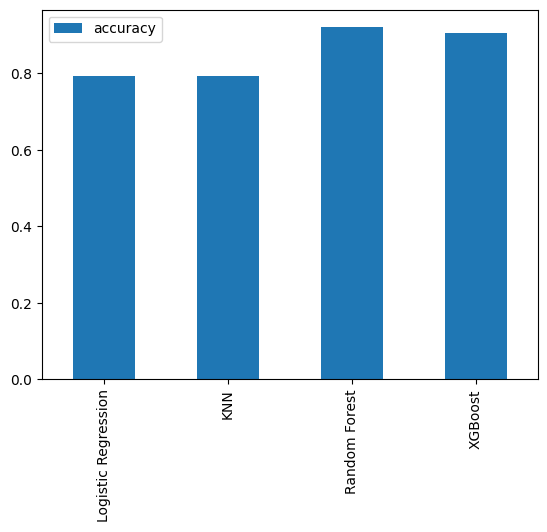

In [22]:
model_scores = {model:stats["scores"]for model, stats in output.items()}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

In [23]:
# Check most missed labelled data
for model_name, model_stats in output.items():
    y_preds = model_stats["y_preds"]
    missed = np.where(y_preds != y_test)[0]
    features_to_pay_attention_to = y_test[missed]
    y_original = le_step1.inverse_transform(features_to_pay_attention_to)
    print(y_original)
    print(f"{model_name} missed: {missed}")

['IfcFooting' 'IfcPlate' 'IfcFooting' 'IfcFooting' 'IfcWall' 'IfcBeam'
 'IfcFooting' 'IfcFooting' 'IfcFooting' 'IfcPlate' 'IfcCurtainWall'
 'IfcColumn' 'IfcPlate']
Logistic Regression missed: [12 13 17 18 30 32 33 36 38 39 48 55 61]
['IfcFooting' 'IfcPlate' 'IfcFooting' 'IfcFooting' 'IfcCurtainWall'
 'IfcRoof' 'IfcFooting' 'IfcFooting' 'IfcPlate' 'IfcCurtainWall'
 'IfcColumn' 'IfcFooting' 'IfcPlate']
KNN missed: [11 13 14 17 21 22 33 36 39 48 55 56 61]
['IfcPlate' 'IfcPlate' 'IfcCurtainWall' 'IfcPlate' 'IfcWall']
Random Forest missed: [13 39 48 61 62]
['IfcBeam' 'IfcPlate' 'IfcRoof' 'IfcBeam' 'IfcPlate' 'IfcPlate']
XGBoost missed: [ 7 13 22 32 39 61]


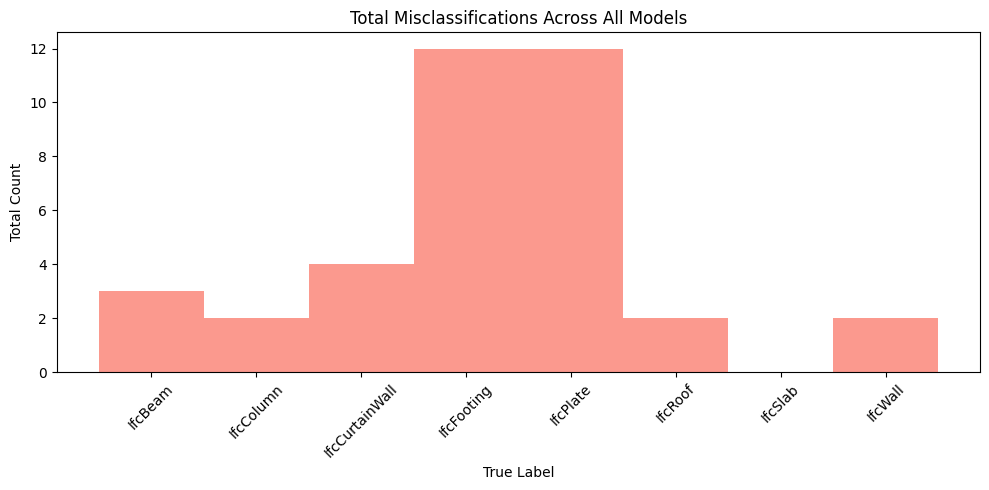

In [24]:
import matplotlib.pyplot as plt
# Collect all misclassified labels across all models
all_missed_labels = []

for model_name, model_stats in output.items():
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]
    all_missed_labels.extend(missed_labels)

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(all_missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, color='salmon', alpha=0.8)

plt.title("Total Misclassifications Across All Models")
plt.xlabel("True Label")
plt.ylabel("Total Count")
plt.xticks(np.arange(len(le_step1.classes_)), labels=le_step1.classes_, rotation=45)
plt.tight_layout()
plt.show()

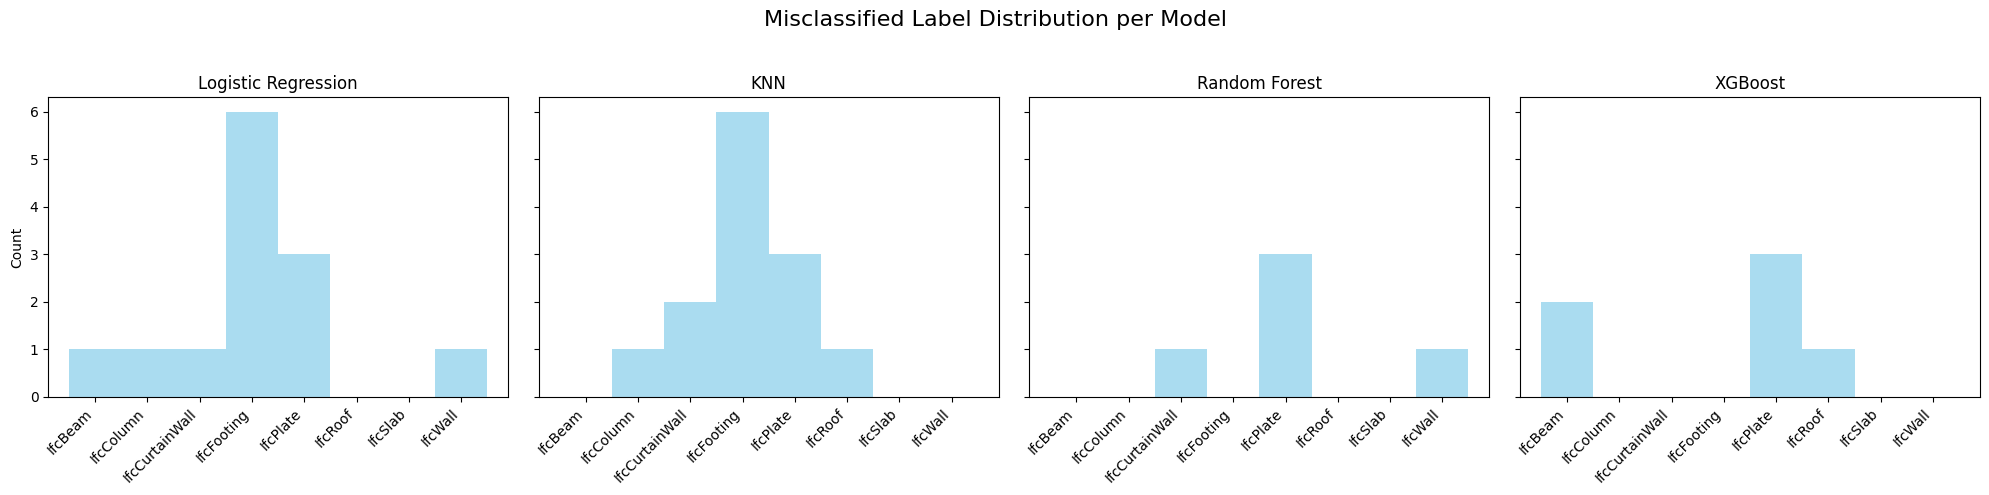

In [25]:
import matplotlib.pyplot as plt

num_models = len(output)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

for ax, (model_name, model_stats) in zip(axes, output.items()):
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]

    ax.hist(missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, alpha=0.7, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xticks(np.arange(len(le_step1.classes_)))
    ax.set_xticklabels(le_step1.classes_, rotation=45, ha='right')

axes[0].set_ylabel("Count")
fig.suptitle("Misclassified Label Distribution per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Observing that Random Forest and XG boost are good at different types idetification. There are two directions to go

*   🧭 Option 1: Voting Ensemble (Random Forest + XGBoost)
*   🛠️ Option 2: Fine-Tune XGBoost

# Voting Ensemble (Random Forest + XGBoost)

In [26]:
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ],
    voting='soft'  # Use probabilities instead of hard voting
)
ensemble.fit(x_train, y_train)
ensemble_score = ensemble.score(x_test, y_test)
y_preds = ensemble.predict(x_test)
print(f"Ensemble Accuracy: {ensemble_score}")

Ensemble Accuracy: 0.9523809523809523


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Logistic Regression': 0.7936507936507936, 'KNN': 0.7936507936507936, 'Random Forest': 0.9206349206349206, 'XGBoost': 0.9047619047619048, 'Ensemble': 0.9523809523809523}


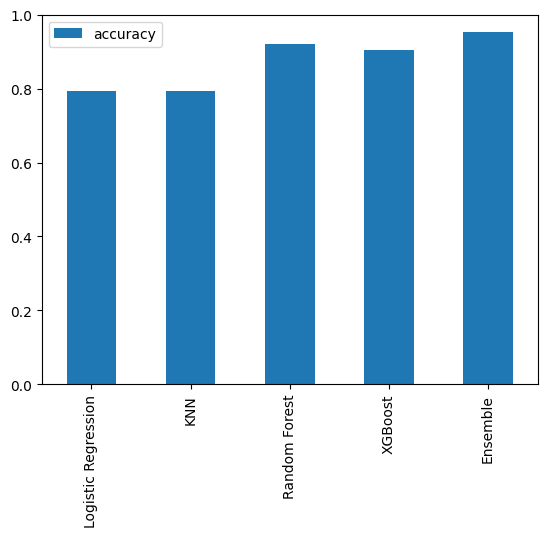

In [27]:
model_scores = {model:stats["scores"]for model, stats in output.items()} | {"Ensemble": ensemble_score}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

# Fine-Tune XGBoost

hyperparameter tuning using Grid Search or Randomized Search.

In [28]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

In [29]:
grid_search = GridSearchCV(
    estimator= xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation same as our test_split
    verbose=1,
    n_jobs=-1  # Use all cores
)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best score: 0.9394285714285713


In [30]:
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(
    estimator= xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=20,         # Try 20 random combinations
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train, y_train)

print("Best parameters for random search:", random_search.best_params_)
print("Best score for random search:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for random search: {'learning_rate': np.float64(0.19771054180315006), 'max_depth': 4, 'n_estimators': 291, 'subsample': np.float64(0.9976634677873653)}
Best score for random search: 0.9234285714285713


We can now combine the best search parameters to create a new ensemble models and see if it could be even better !

In [31]:
# Get the best param setting:
if random_search.best_score_ > grid_search.best_score_:
  used_params = random_search.best_params_
  best_scores = random_search.best_score_
else:
  used_params = grid_search.best_params_
  best_scores = grid_search.best_score_

In [32]:
if best_scores > output['XGBoost']["scores"]:
  print("New found params outperform original XGB Boost, try new ensemble")
  new_ensemble = VotingClassifier(
      estimators=[
          ('rf', RandomForestClassifier()),
          ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **used_params))
      ],
      voting='soft'  # Use probabilities instead of hard voting
  )
  new_ensemble.fit(x_train, y_train)
  new_ensemble_score = new_ensemble.score(x_test, y_test)
  y_preds = new_ensemble.predict(x_test)
  print(f"Ensemble Accuracy: {new_ensemble_score}")

New found params outperform original XGB Boost, try new ensemble


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Accuracy: 0.9365079365079365


An obeservation here is that a better performing XGB model results in a lower ensemble so we might need to investigate but since the original ensemble is still highest performing model and the score is around 94% it is good enough as a base model.

# Train a Second model using only cluster relatonship

In [33]:
df2 = pd.DataFrame(contextual_features)
df2.head()

,upper,lower,left,right,number_of_neighbours_of_same_type,HR_None,HR_IfcWall,HR_IfcSlab,HR_IfcRoof,HR_IfcColumn,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,0,0,37,2,1,0,...,0.00,0.00,0.000000,0.040000,0.000000,6.953317,0.000000,4.651975,0.000000,1.000000
1,IfcSlab,None,IfcBeam,IfcSlab,3,0,37,9,1,0,...,0.11,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
2,IfcWall,IfcCurtainWall,IfcColumn,IfcSlab,3,0,37,9,1,0,...,0.11,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
3,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,0,0,38,2,0,3,...,0.00,0.00,0.000000,0.040000,0.000000,6.070073,0.000000,3.491121,0.000000,1.000000
4,IfcSlab,None,IfcBeam,IfcSlab,2,0,37,4,0,1,...,0.16,0.30,1.893989,2.752536,3.972467,2.174563,11.625536,0.187362,0.003512,0.333333


We need to first transform the features into labels and do one hot encode for the horizontal and vertical relatives

In [34]:
#Manually label data
label_map = {
    "None": 0,
    "IfcWall": 1,
    "IfcSlab": 2,
    "IfcRoof": 3,
    "IfcColumn": 4,
    "IfcBeam": 5,
    "IfcCurtainWall": 6,
    "IfcFooting": 7,
    "IfcPlate": 8
}
inv_map = {v: k for k, v in label_map.items()}

In [35]:
#Label the upper,lower,right,left column
cols = ["upper", "lower", "left", "right"]
for col in cols:
  df2[col] = df2[col].fillna("None")
  df2[col] = df2[col].map(label_map)
df2.head(4)

,upper,lower,left,right,number_of_neighbours_of_same_type,HR_None,HR_IfcWall,HR_IfcSlab,HR_IfcRoof,HR_IfcColumn,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,6,6,6,6,0,0,37,2,1,0,...,0.00,0.00,0.00000,0.040000,0.000000,6.953317,0.000000,4.651975,0.000000,1.000000
1,2,0,5,2,3,0,37,9,1,0,...,0.11,0.29,2.52134,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
2,1,6,4,2,3,0,37,9,1,0,...,0.11,0.29,2.52134,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
3,6,6,6,6,0,0,38,2,0,3,...,0.00,0.00,0.00000,0.040000,0.000000,6.070073,0.000000,3.491121,0.000000,1.000000


Here we should use the y_preds to get the cluster information but since we are using the data where the cluster is determined, we can run the models to see whether adding cluster features can help boost perfomrance as a test of our statement

In [36]:
np.random.seed(42)
x2 = df2
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x2, y_step1_encoded, test_size=0.2)

Fine tune XG boost first

In [37]:
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(
    estimator= xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=20,         # Try 20 random combinations
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train, y_train)

print("Best parameters for random search:", random_search.best_params_)
print("Best score for random search:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for random search: {'learning_rate': np.float64(0.0849080237694725), 'max_depth': 7, 'n_estimators': 114, 'subsample': np.float64(0.9195981825434215)}
Best score for random search: 0.9836734693877551


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [38]:
models_1 = {
    'Logistic Regression' : make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',**random_search.best_params_)
}
output = fit_and_score(models_1, x_train, x_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Logistic Regression': 0.9841269841269841, 'KNN': 0.9206349206349206, 'Random Forest': 1.0, 'XGBoost': 0.9682539682539683}


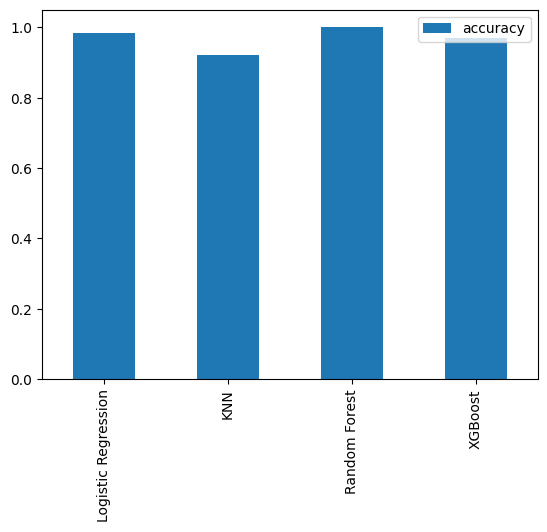

In [39]:
model_scores = {model:stats["scores"]for model, stats in output.items()}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

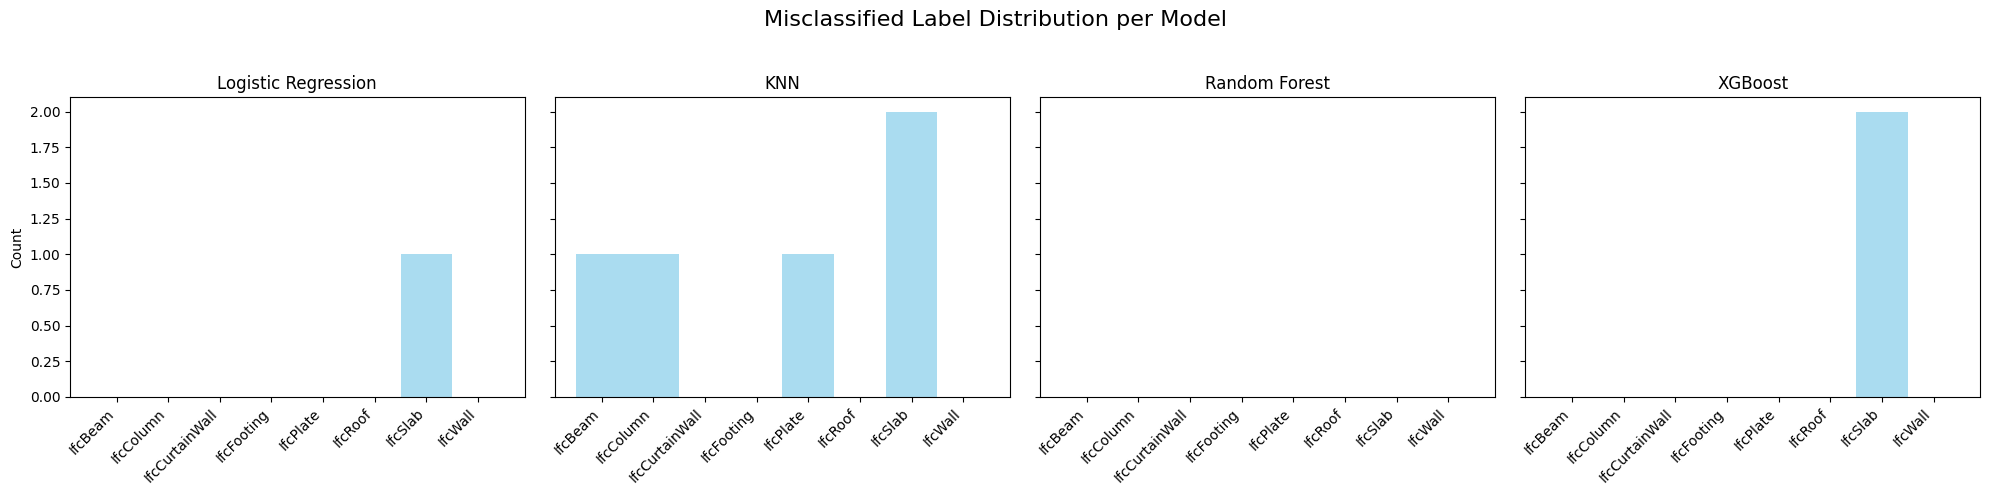

In [40]:
import matplotlib.pyplot as plt

num_models = len(output)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

for ax, (model_name, model_stats) in zip(axes, output.items()):
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]

    ax.hist(missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, alpha=0.7, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xticks(np.arange(len(le_step1.classes_)))
    ax.set_xticklabels(le_step1.classes_, rotation=45, ha='right')

axes[0].set_ylabel("Count")
fig.suptitle("Misclassified Label Distribution per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Combine both intrinsic and contextural data

In [41]:
df1 = df1.drop("target", axis =1)
df_combined = pd.concat([df1, df2], axis=1)
df_combined

,AABB_X_Extent,OOBB_X_Extent,AABB_Y_Extent,OOBB_Y_Extent,AABB_Z_Extent,OOBB_Z_Extent,AABB_base_area,OOBB_Base_area,World_X_Extent,World_Y_Extent,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,4.69,4.651975,6.78,6.953317,0.04,0.040000,15.94,32.35,27.68,13.68,...,0.00,0.00,0.000000,0.040000,0.000000,6.953317,0.000000,4.651975,0.000000,1.000000
1,1.98,0.280000,3.70,0.202695,0.28,4.058783,0.80,0.06,27.68,13.68,...,0.11,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
2,3.44,4.458813,3.08,0.199449,0.28,0.280000,0.87,0.89,27.68,13.68,...,0.11,0.29,2.521340,2.626977,2.671894,2.506474,12.370717,0.185380,0.003152,0.333333
3,4.18,3.491121,6.53,6.070073,0.04,0.040000,15.59,21.19,27.68,13.68,...,0.00,0.00,0.000000,0.040000,0.000000,6.070073,0.000000,3.491121,0.000000,1.000000
4,0.57,0.280000,1.78,0.206350,0.28,1.831194,0.33,0.06,27.68,13.68,...,0.16,0.30,1.893989,2.752536,3.972467,2.174563,11.625536,0.187362,0.003512,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.20,0.200000,0.20,0.200000,2.60,2.600000,0.04,0.04,27.68,13.68,...,0.00,0.00,0.000000,2.600000,0.000000,0.200000,0.000000,0.200000,0.000000,1.000000
308,0.20,0.200000,0.20,0.200000,2.72,2.720000,0.04,0.04,27.68,13.68,...,0.00,0.00,0.000000,2.720000,0.000000,0.200000,0.000000,0.200000,0.000000,1.000000
309,0.07,0.070000,5.18,5.180000,10.06,10.060000,0.36,0.36,27.68,13.68,...,0.28,0.25,1.115235,5.081679,7.066087,5.148119,7.659354,0.077130,0.000055,0.347826
310,0.20,0.200000,0.20,0.200000,5.64,5.640000,0.04,0.04,27.68,13.68,...,0.00,0.00,0.000000,5.640000,0.000000,0.200000,0.000000,0.200000,0.000000,1.000000


In [42]:
np.random.seed(42)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_combined, y_step1_encoded, test_size=0.2)

In [43]:
models_2 = {
    'Logistic Regression' : make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}
output = fit_and_score(models_2, x_train, x_test, y_train, y_test)

{'Logistic Regression': 0.9841269841269841, 'KNN': 0.9365079365079365, 'Random Forest': 1.0, 'XGBoost': 0.9365079365079365}


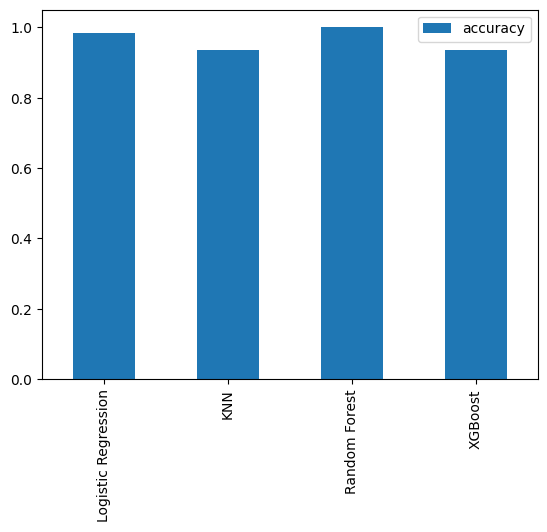

In [44]:
model_scores = {model:stats["scores"]for model, stats in output.items()}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

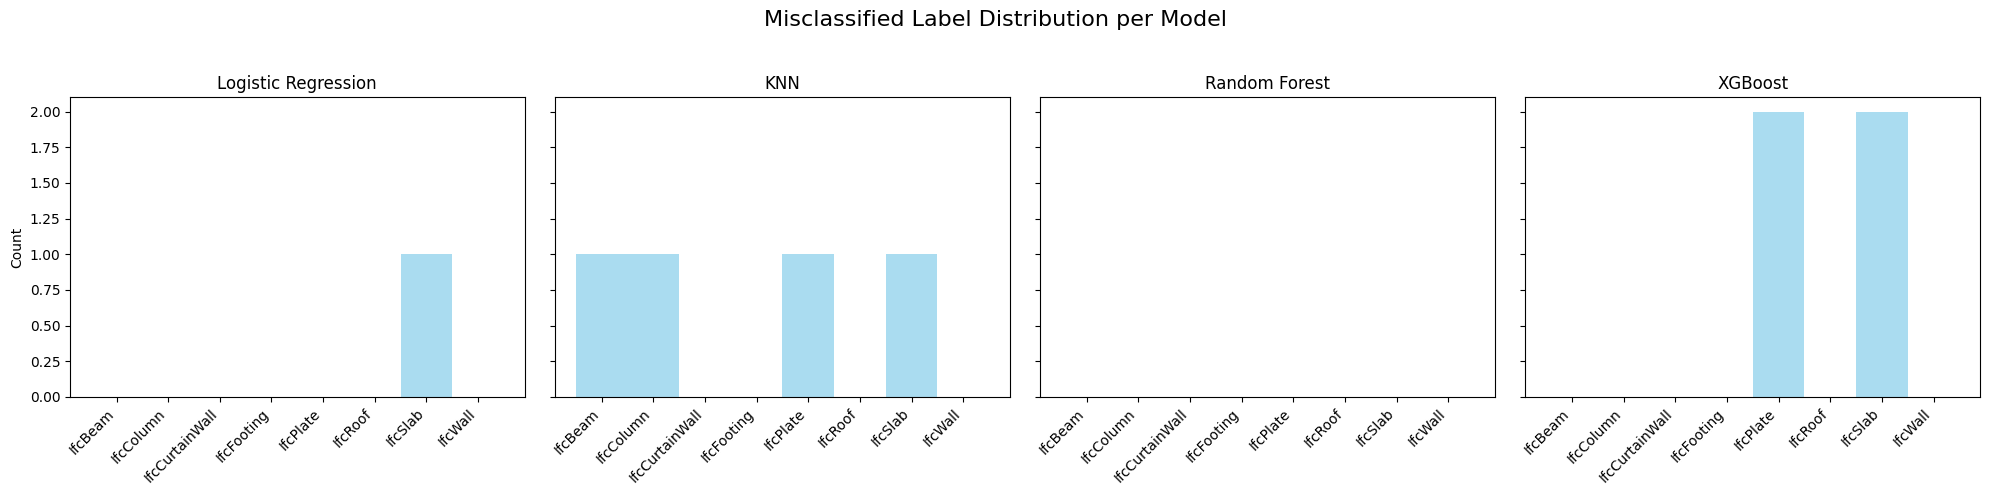

In [45]:
import matplotlib.pyplot as plt

num_models = len(output)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

for ax, (model_name, model_stats) in zip(axes, output.items()):
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]

    ax.hist(missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, alpha=0.7, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xticks(np.arange(len(le_step1.classes_)))
    ax.set_xticklabels(le_step1.classes_, rotation=45, ha='right')

axes[0].set_ylabel("Count")
fig.suptitle("Misclassified Label Distribution per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

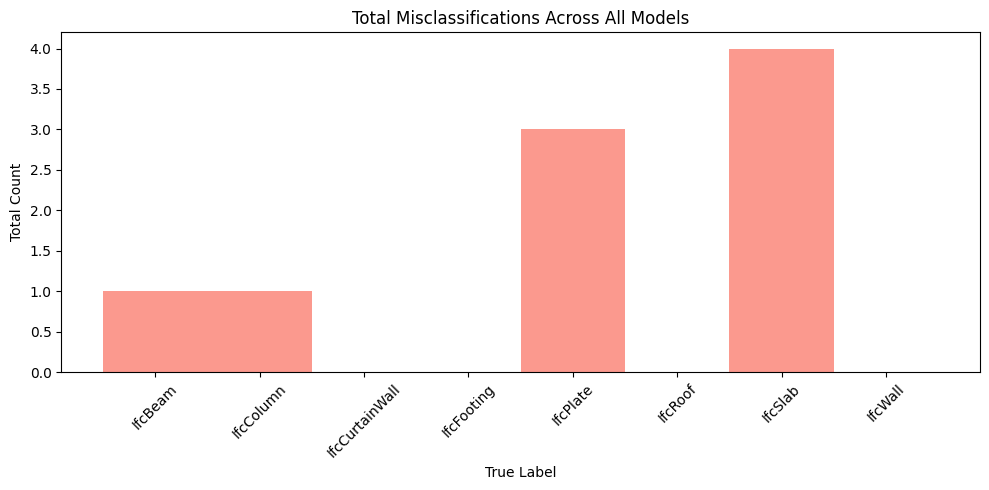

In [46]:
import matplotlib.pyplot as plt
# Collect all misclassified labels across all models
all_missed_labels = []

for model_name, model_stats in output.items():
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]
    all_missed_labels.extend(missed_labels)

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(all_missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, color='salmon', alpha=0.8)

plt.title("Total Misclassifications Across All Models")
plt.xlabel("True Label")
plt.ylabel("Total Count")
plt.xticks(np.arange(len(le_step1.classes_)), labels=le_step1.classes_, rotation=45)
plt.tight_layout()
plt.show()

Proof of Concept:
1. Learning from graph contextual data yields higher accuracy
2. Neighbouts node can help determine the nature of unlabelled node

